In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import solve
from scipy.special import gamma, kv
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
# simplest ground truth function
def ground_truth(x, y, z):
  return torch.sin(2 * np.pi * (x + y + z))

In [11]:
# Define the Laplacian operator
def laplacian(f, x, y, z):
    # Ensure inputs require gradients
    x.requires_grad_(True)
    y.requires_grad_(True)
    z.requires_grad_(True)

    # Compute first-order gradients
    f_val = f(x, y, z)
    grad_f_x = torch.autograd.grad(f_val, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    grad_f_y = torch.autograd.grad(f_val, y, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    grad_f_z = torch.autograd.grad(f_val, z, grad_outputs=torch.ones_like(z), create_graph=True)[0]

    # Compute second-order gradients
    laplacian_f_x = torch.autograd.grad(grad_f_x, x, grad_outputs=torch.ones_like(grad_f_x), create_graph=True)[0]
    laplacian_f_y = torch.autograd.grad(grad_f_y, y, grad_outputs=torch.ones_like(grad_f_y), create_graph=True)[0]
    laplacian_f_z = torch.autograd.grad(grad_f_z, z, grad_outputs=torch.ones_like(grad_f_z), create_graph=True)[0]

    # Sum second-order derivatives
    laplacian_f = laplacian_f_x + laplacian_f_y + laplacian_f_z

    return laplacian_f

# Define the second-order Laplacian operator for tensor inputs
def second_order_laplacian(f, x, y, z):
    laplace_f = laplacian(f, x, y, z)
    return laplacian(lambda x, y, z: laplace_f, x, y, z)

In [4]:
x = torch.tensor([0.25, 1], dtype = float)
y = torch.tensor([0.25, 1], dtype = float)
z = torch.tensor([0.25, 1], dtype = float)
print('laplacian:', laplacian(ground_truth, x, y, z))
print('second_order_laplacian:', second_order_laplacian(ground_truth, x, y, z))

laplacian: tensor([1.1844e+02, 8.7025e-14], dtype=torch.float64, grad_fn=<AddBackward0>)
second_order_laplacian: tensor([-1.4027e+04, -1.0307e-11], dtype=torch.float64, grad_fn=<AddBackward0>)


In [12]:
# Generate data
def generate_data(n, operator, noise_std=0.1):
    x = torch.rand(n, 3)
    print('x shape:', x.shape)
    Af = laplacian(ground_truth, x.T[0], x.T[1], x.T[2]) # Af(x)
    epsilon = torch.normal(0, noise_std, size = (n, 1)).squeeze()
    print('Af shape:', Af.shape)
    print('epsilon shape:', epsilon.shape)
    y = Af + epsilon
    y = y.unsqueeze(1)
    print('y shape', y.shape)
    return x.detach().cuda(), y.detach().cuda()

In [13]:
# Experiments
num_train = 10000
num_test  = 10000

# generate data
x_train, y_train_inv = generate_data(num_train, laplacian)
x_test, y_test_inv = generate_data(num_train, laplacian)

beta, beta_prime = 1, 1

print('x_train:', x_train[:10]) # x
print('y_train_inv:', y_train_inv[:10]) # Af(x) + epsilon

x shape: torch.Size([10000, 3])
Af shape: torch.Size([10000])
epsilon shape: torch.Size([10000])
y shape torch.Size([10000, 1])
x shape: torch.Size([10000, 3])
Af shape: torch.Size([10000])
epsilon shape: torch.Size([10000])
y shape torch.Size([10000, 1])
x_train: tensor([[0.9032, 0.8971, 0.7583],
        [0.7939, 0.8792, 0.5858],
        [0.8642, 0.9386, 0.9218],
        [0.2367, 0.4291, 0.3422],
        [0.7320, 0.8674, 0.7661],
        [0.4585, 0.8839, 0.4641],
        [0.4936, 0.3047, 0.2486],
        [0.3590, 0.9213, 0.6258],
        [0.9611, 0.5403, 0.9496],
        [0.9704, 0.2314, 0.0721]], device='cuda:0')
y_train_inv: tensor([[  42.6894],
        [-118.2847],
        [ 116.8415],
        [  -5.9931],
        [ -88.6641],
        [ 110.9807],
        [ -34.3862],
        [  65.8743],
        [ -36.0805],
        [-117.2616]], device='cuda:0')


In [14]:
# Neural Network with custom activation
class CustomNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        #self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        #x = self.activation(self.fc3(x))
        #x = self.fc4(x)
        x = self.fc3(x)
        return x

# Activation functions
class ReLUPower(nn.Module):
    def __init__(self, power):
        super(ReLUPower, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.relu(x) ** self.power

# Train neural network
def train_nn(model, X_train, y_train, X_test, y_test, epochs=1000, lr=1e-3):
    criterion = nn.MSELoss() # loss's problem

    #optimizer = optim.LBFGS(model.parameters(), lr=lr)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    optimizer = optim.Adam([
                {'params': model.parameters()}
            ],lr = lr, betas = (0.9, 0.999), eps = 1e-8, weight_decay = 1e-4)
    
    from torch.optim.lr_scheduler import StepLR
    scheduler =  StepLR(optimizer, step_size=2000, gamma=0.7)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)

    loss_history = []
    test_error_history = []

    for epoch in range(epochs):
        model.train()
        # LBFGS optimizer
        # def closure():
        #     outputs = model(X_train)
        #     loss = criterion(outputs, y_train)
        #     optimizer.zero_grad()
        #     loss.backward()
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        #     return loss

        # loss = optimizer.step(closure)
        # #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        # loss_history.append(loss.item())

        # Adam optimizer
        outputs = model(X_train)
        
        #print('outputs:', outputs[:10])
        #print('y_train:', y_train[:10])
        
        loss = criterion(outputs, y_train)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()
        scheduler.step(loss)

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_loss = criterion(test_outputs, y_test)
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {test_loss.item():.4f}')
                test_error_history.append(test_loss.item())
            model.train()

    return loss_history, test_error_history

x_train shape: torch.Size([10000, 3])
y_train_inv: torch.Size([10000, 1])
Epoch [100/20000], Loss: 7058.5601
Epoch [100/20000], Loss: 7003.7520
Epoch [200/20000], Loss: 7043.2568
Epoch [200/20000], Loss: 6992.9551
Epoch [300/20000], Loss: 7023.7168
Epoch [300/20000], Loss: 6977.3853
Epoch [400/20000], Loss: 6998.3726
Epoch [400/20000], Loss: 6955.2710
Epoch [500/20000], Loss: 6966.7373
Epoch [500/20000], Loss: 6926.6265
Epoch [600/20000], Loss: 6927.1084
Epoch [600/20000], Loss: 6889.4214
Epoch [700/20000], Loss: 6881.4463
Epoch [700/20000], Loss: 6845.6304
Epoch [800/20000], Loss: 6827.6240
Epoch [800/20000], Loss: 6793.6860
Epoch [900/20000], Loss: 6765.1504
Epoch [900/20000], Loss: 6733.1719
Epoch [1000/20000], Loss: 6694.9238
Epoch [1000/20000], Loss: 6664.6626
Epoch [1100/20000], Loss: 6616.1079
Epoch [1100/20000], Loss: 6587.3623
Epoch [1200/20000], Loss: 6525.5200
Epoch [1200/20000], Loss: 6498.5967
Epoch [1300/20000], Loss: 6420.2314
Epoch [1300/20000], Loss: 6396.4785
Epoch [1

KeyboardInterrupt: 

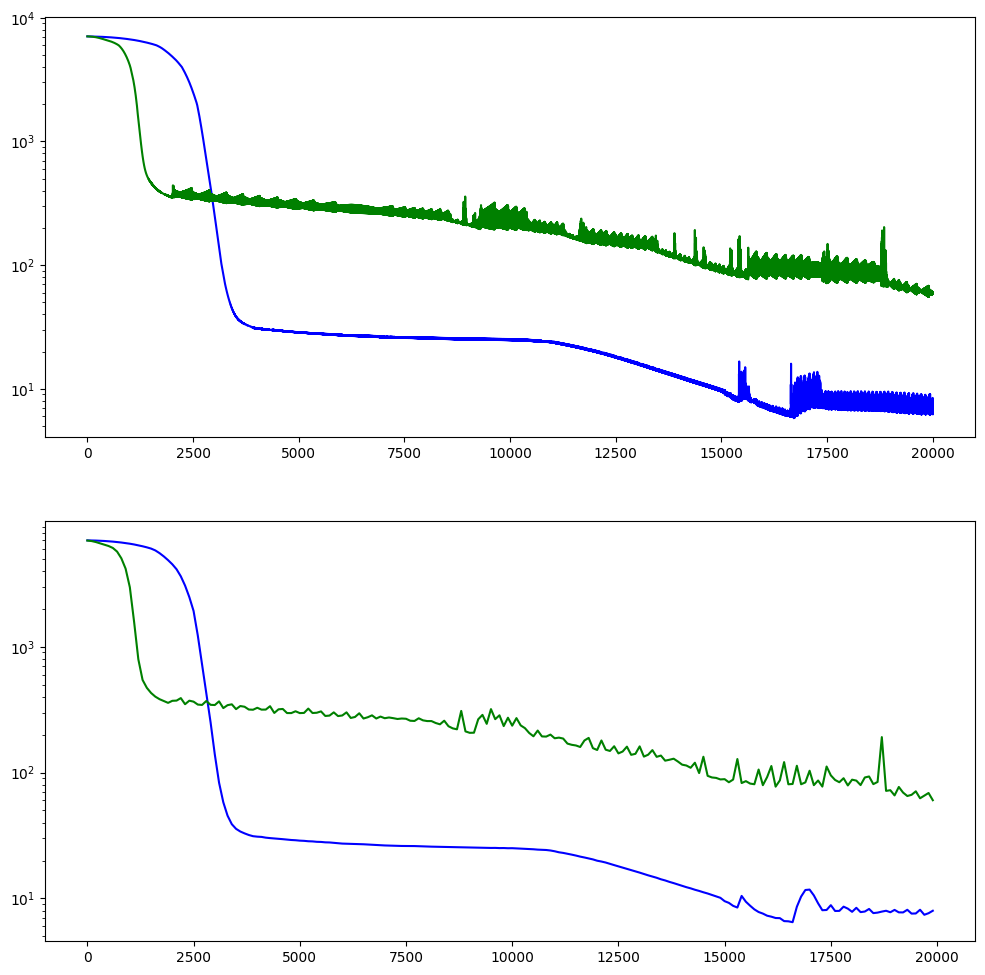

In [16]:
# Experiment 1: Neural Networks with different activations
epochs = 20000 # 10,0000
activations = [nn.ReLU(), ReLUPower(2), ReLUPower(3)]
activation_names = ['ReLU', 'ReLU^2', 'ReLU^3']
learning_rates = [1e-3]#[0.05, 0.03, 0.01, 0.1, 0.3, 0.5]#[0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.05]
#lr_act = [0.05, 0.05, 0.01]
colors = ['b', 'g', 'r'] 
#line_styles = ['-', '-.', '--', ':', 
line_styles = ['-']#['-', '-.', '--', ':', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (5, 10))]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.set_yscale('log')
ax2.set_yscale('log')

for act, name, color in zip(activations, activation_names, colors):
    for lr, line_style in zip(learning_rates, line_styles):
        # input_dim, hidden_dim, output_dim, activation
        model = CustomNN(3, 64, 1, act).cuda()
        model.apply(lambda m: nn.init.kaiming_normal_(m.weight) if isinstance(m, nn.Linear) else None)

        print('x_train shape:', x_train.shape)
        print('y_train_inv:', y_train_inv.shape)

        loss_history, test_error_history = train_nn(model, x_train, y_train_inv, x_test, y_test_inv, epochs = epochs, lr=lr)

        # Plot training loss
        ax1.plot(loss_history, label=f'{name} Activation - Train Loss (lr={lr})', color=color, linestyle = line_style)
        # Plot test error
        ax2.plot(range(0, epochs, 100), test_error_history, label=f'{name} Activation - Test Error (lr={lr})', color=color, linestyle = line_style)

ax1.legend()
ax1.set_title('Training Loss for Different Activations')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.legend()
ax2.set_title('Test Error for Different Activations')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()
# Calculate and print variances
# print(f"Variance (Matérn Kernel): {np.var(y_pred_inv)}")
# for act, name in zip(activations, activation_names):
#     with torch.no_grad():
#         y_pred = model(x_test.numpy())
#     print(f"Variance ({name}): {np.var(y_pred)}")

In [ ]:
# Matérn kernel
def matern_kernel(X1, X2, nu=2.5, length_scale=1.0):
    d = cdist(X1 / length_scale, X2 / length_scale)
    if nu == 0.5:
        K = np.exp(-d)
    elif nu == 1.5:
        K = (1 + np.sqrt(3) * d) * np.exp(-np.sqrt(3) * d)
    elif nu == 2.5:
        K = (1 + np.sqrt(5) * d + 5/3 * d**2) * np.exp(-np.sqrt(5) * d)
    else:
        K = 2**(1-nu) / gamma(nu) * (np.sqrt(2*nu) * d)**nu * kv(nu, np.sqrt(2*nu) * d)
    return K

In [ ]:
# Kernel Ridge Regression
# need to use the new representer theorem
def kernel_ridge_regression(X_train, y_train, X_test, kernel_func, lambda_reg=1e-5):
    K = kernel_func(X_train.reshape(-1, 1), X_train.reshape(-1, 1))
    alpha = solve(K + lambda_reg * np.eye(len(X_train)), y_train)
    K_test = kernel_func(X_test.reshape(-1, 1), X_train.reshape(-1, 1))
    return K_test @ alpha

In [ ]:
covariance_matrix = matern_kernel(x_train.cpu().numpy(), x_train.cpu().numpy())
print('covariance matrix shape:', covariance_matrix.shape)

In [ ]:
# Experiment 2: Kernel Ridge Regression with Matérn kernel
y_pred_inv = kernel_ridge_regression(x_train, y_train_inv, x_test, lambda X1, X2: matern_kernel(X1, X2, nu=2.5))

print(x_test[:10])
print(np.sin(2 * np.pi * x_test)[:10])
print(laplacian(np.sin(2 * np.pi * x_test))[:10])

[0.         0.001001   0.002002   0.003003   0.004004   0.00500501
 0.00600601 0.00700701 0.00800801 0.00900901]
[0.         0.00628943 0.01257862 0.0188673  0.02515525 0.03144219
 0.03772789 0.0440121  0.05029457 0.05657505]
[-6.28943332e-03  2.48793394e-07  4.97576947e-07  7.46340817e-07
  9.95075164e-07  1.24377015e-06  1.49241593e-06  1.74100268e-06
  1.98952056e-06  2.23795974e-06]


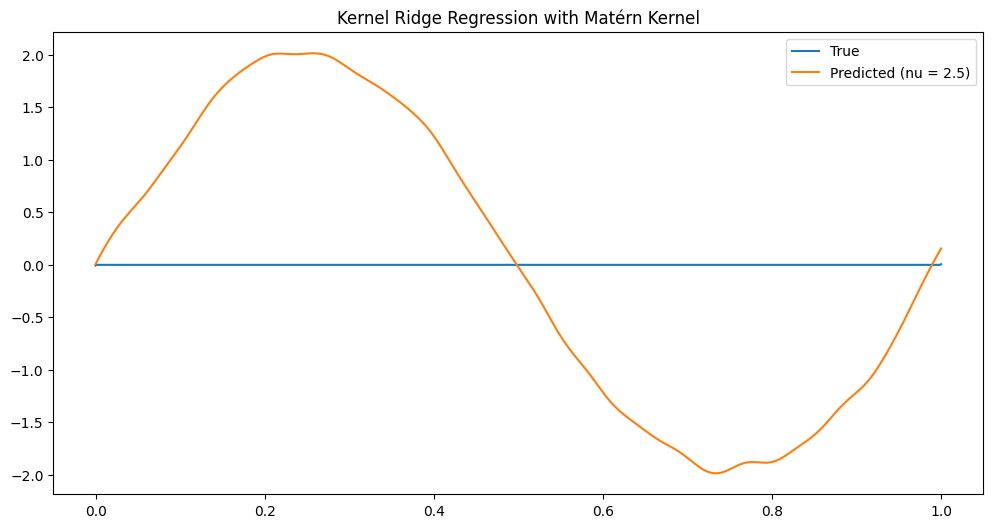

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x_test, laplacian(np.sin(2 * np.pi * x_test)), label='True')
plt.plot(x_test, y_pred_inv, label='Predicted (nu = 2.5)')
plt.legend()
plt.title('Kernel Ridge Regression with Matérn Kernel')
plt.show()